# Телеком


Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Цель проекта

Создать модель машинного обучения, которая способна с высокой вероятностью предсказывать возможный уход клиента, чтобы компания могла попытаться его удержать заранее предложив промокоды и специальные условия.   
  
Целевая метрика ROC-AUC >= 0.85 и accuracy.  

# Исследовательский анализ данных

Для начала импортируем пакеты и загрузим датасет

In [237]:
import os
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [238]:
BASE_DIR = os.getcwd()

df_contract = pd.read_csv(f"{BASE_DIR}/datasets/contract_new.csv")
df_internet = pd.read_csv(f"{BASE_DIR}/datasets/internet_new.csv")
df_personal = pd.read_csv(f"{BASE_DIR}/datasets/personal_new.csv")
df_phone = pd.read_csv(f"{BASE_DIR}/datasets/phone_new.csv")

Изучим датафреймы

### df_contract

In [239]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [240]:
df_contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [241]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Датафрейм содержит следующие признаки:
- `customerID` - идентификатор пользователя (ключ по которому объединяются таблицы);
- `BeginDate` - дата заключения договора;
- `EndDate` - дата закрытия договора (если абонент отказался от услуг провайдера, по сути это и есть целевой признак);
- `Type` - тип контракта по длительности периода оплаты (ежемесячная оплата, ежегодная оплата, оплата каждые два года);
- `PaperlessBilling` - тип получения квитанции об оплате;
- `PaymentMethod` - способ оплаты услуг;
- `MonthlyCharges` - стоимость услуг в пересчёте на месяц;
- `TotalCharges` - суммарная стоимость услуг за весь период.

### df_personal

In [242]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Датафрейм содержит следующие признаки:
- `customerID` - идентификатор пользователя (ключ по которому объединяются таблицы);
- `gender` - пол абонента;
- `seniorCitizen` - является ли абонент пенсионером по возрасту;
- `Partner` - наличие/отсутствие партнёра;
- `Dependents` - наличие/отсутствие иждевенцев.

In [243]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


### df_internet

In [244]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [245]:
df_internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [246]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Датафрейм содержит следующие признаки:
- `customerID` - идентификатор пользователя (ключ по которому объединяются таблицы);
- `InternetService` - тип подключения (DSL, fiber optic);
- `OnlineSecurity` - блокировка небезопасных сайтов;
- `OnlineBackup` - облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` - антивирус;
- `TechSupport` - выделенная линия технической поддержки;
- `StreamingTV`- стриминговое телевидение;
- `StreamingMovies`- каталог фильмов.  

Кроме `customer_ID` все признаки датафрейма бинарные и могут быть преобразованы в булевый тип данных.

### df_phone

In [247]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [248]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Датафрейм содержит следующие признаки:
- `customerID` - идентификатор пользователя (ключ по которому объединяются таблицы);
- `MultipleLines` - количество линий домашней телефонии подключенных у абонента - одна/более одной.

Проверим дубликаты.

In [249]:
print(df_contract.duplicated().sum())
print(df_personal.duplicated().sum())
print(df_internet.duplicated().sum())
print(df_phone.duplicated().sum())

0
0
0
0


Дубликаты в данных отсутствуют.

Проверим совпадает ли количество `customerID` 

In [250]:
print(len(df_contract['customerID'].unique()))
print(len(df_personal['customerID'].unique()))
print(len(df_internet['customerID'].unique()))
print(len(df_phone['customerID'].unique()))

7043
7043
5517
6361


Количество `customerID` одинаковое в датафреймах `df_contract` и `df_personal`, первый содержит информацию о договоре, а второй персональные данные клиента. В двух других датасетах, а именно `internet_new.csv` — информация об интернет-услугах и `phone_new.csv` — информация об услугах телефонии количество записей меньше. Т.к. не все пользователи пользуются всеми предоставляемыми услугами в этих датафреймах закономерно меньше объектов.

Пропуски и дубликаты в данных отсутствуют.  
Заголовки не приведены к единому стандарту.  
Типы зачастую не соответствует сути хранимых данных.  
Все датафремы необходимо объединить в один по ключу `customerID`.
Из датафрейма `df_contract` необходимо выделить целевой признак. Если в столбце `EndDate` указана дата, значит абонент ушёл из компании. В той же таблице есть столбец `BeginDate`, мы можем получить количество дней когда абонент был клиентом компании и удалить оба исходных признака.
  
Почти все признаки бинарные категориальные, целесообразно обработать их OHE энкодером.  

## Предобработка данных

Объединим датафреймы в один

In [251]:
df = df_contract.merge(df_personal, on = 'customerID')
df = df.merge(df_internet, on = 'customerID', how = 'left')
df = df.merge(df_phone, on = 'customerID', how = 'left')

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Удалим `customerID` т.к. он нам больше не понадобиться, он использовался только для объединения таблиц.

In [253]:
df = df.drop('customerID', axis=1)

In [254]:
df.columns

Index(['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines'],
      dtype='object')

Приведём заголовки к `camelCase`

In [255]:
df.columns = df.columns.str[0].str.lower() + df.columns.str[1:]

In [256]:
df.columns

Index(['beginDate', 'endDate', 'type', 'paperlessBilling', 'paymentMethod',
       'monthlyCharges', 'totalCharges', 'gender', 'seniorCitizen', 'partner',
       'dependents', 'internetService', 'onlineSecurity', 'onlineBackup',
       'deviceProtection', 'techSupport', 'streamingTV', 'streamingMovies',
       'multipleLines'],
      dtype='object')

Преобразуем типы данных.

In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   beginDate         7043 non-null   object 
 1   endDate           7043 non-null   object 
 2   type              7043 non-null   object 
 3   paperlessBilling  7043 non-null   object 
 4   paymentMethod     7043 non-null   object 
 5   monthlyCharges    7043 non-null   float64
 6   totalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   seniorCitizen     7043 non-null   int64  
 9   partner           7043 non-null   object 
 10  dependents        7043 non-null   object 
 11  internetService   5517 non-null   object 
 12  onlineSecurity    5517 non-null   object 
 13  onlineBackup      5517 non-null   object 
 14  deviceProtection  5517 non-null   object 
 15  techSupport       5517 non-null   object 
 16  streamingTV       5517 non-null   object 


Т.к. все категориальные признаки мы будем преобразовывать с помощью OHE, сейчас нам необходимо привести `totalCharges` к типу `float`, а также `beginDate` и `endDate` к типу `datetime`.

In [258]:
df['totalCharges'] = df['totalCharges'].replace(" ", 0).astype('float32')

Выделим целевой признак из `beginDate`, если объект содержит значение `No`, значит действие договора не прекращено и значение целевого признака `0`, иначе `1`

In [259]:
df['exited'] = np.where(df['endDate'] == 'No', 0, 1)

Столбец `endDate` содержит значения `No`, если действие договора ещё не прекращено. Так как информация актуальна на 1 февраля 2020, то заменим No в `EndDate` на эту дату.

In [260]:
df['endDate'] = df['endDate'].replace('No', '2020-02-01 00:00:00')
df['endDate'] = pd.to_datetime(df['endDate'], format='%Y-%m-%d')
df['beginDate'] = pd.to_datetime(df['beginDate'], format='%Y-%m-%d')

Создадим признак с продолжительностью действия договора в месяцах.

In [261]:
df['contractDurationMonths'] = (df['endDate'] - df['beginDate'])/np.timedelta64(1, 'M')

Удалим лишние признаки `beginDate`, `endDate`

In [262]:
df = df.drop(['beginDate', 'endDate'], axis=1)

Мы можем облегчить числовые типы данных.

In [263]:
float_cols = df.select_dtypes('float').columns
int_cols = df.select_dtypes('integer').columns

df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')

До объединения количество объектов в таблицах не совпадало, в итоговом датафрейме должны были появиться пропуски.

In [264]:
df.isna().sum()

type                         0
paperlessBilling             0
paymentMethod                0
monthlyCharges               0
totalCharges                 0
gender                       0
seniorCitizen                0
partner                      0
dependents                   0
internetService           1526
onlineSecurity            1526
onlineBackup              1526
deviceProtection          1526
techSupport               1526
streamingTV               1526
streamingMovies           1526
multipleLines              682
exited                       0
contractDurationMonths       0
dtype: int64

Для кодирования категориальных признаков мы можем примернить `OHE` и заодно заполнить пропуски, но так как в планах использовать кросс-валидацию мы сделаем это непосредственно на этапе обучения модели в пайпалайне, а теперь проведём исследователький анализ данных.

# План работ

1. Провести исследовательский анализ данных:
- проанализировать каждый призак в разрезе классов целевого признака.
2. Закончить предобработку данных:
- разделить выборку на фичи и таргет.
3. Обучить модели:
- создать пайплан на основе gridsearchcv. Перед обучением модели использовать one-hot encoder и масштабирование признаков для линейных моделей, также внутри пайплайна необходимо сбаллансировать классы.
- обучить линейную регрессию, случайный лес и кетбуст (кетбуст можно использовать без пайплайна), в качестве функции потерь используем ROC-AUC;
- выбираем лучшую модель, строим ROC кривую и определяем оптимальный порог;
- лучшую модель проверяем на тестовой выборке и сравниваем с константной моделью.
4. Сделать выводы по проведённой работе.

### Анализ данных

Проверим дисбаланс целевой переменной

In [265]:
df['exited'].value_counts()

0    5942
1    1101
Name: exited, dtype: int64

Целевая переменная не сбалансированна, неободимо учесть это на этапе обучения модели.

### Исследование количественных признаков

Попытаемся понять как влияют количественные признаки (месячная и суммарная стоимость услуг) на целевой признак.

In [266]:
# sns.set_theme(style="ticks")
# sns.pairplot(df[['monthlyCharges', 
                #  'totalCharges', 
                #  'contractDurationMonths', 
                #  'exited']], 
                #  hue='exited')
# plt.show()

In [267]:
df['contractDurationMonths'].describe()

count    7043.000000
mean       29.521702
std        22.444197
min         0.000000
25%         9.067948
50%        25.002567
75%        48.000984
max        76.026199
Name: contractDurationMonths, dtype: float64

In [268]:
df['contractDurationMonths'] = round(df['contractDurationMonths'])

In [269]:
months = len(df['contractDurationMonths'].unique())

In [270]:
df_o = df.copy()

In [271]:
df_0 = df[df['exited'] == 0]
df_1 = df[df['exited'] == 1]

In [272]:
# fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

colors = ['red', 'tan']
ax0.hist([df_0['contractDurationMonths'], df_1['contractDurationMonths']], months, density=True, histtype='bar', color=colors, label=colors)
ax0.legend(prop={'size': 10})
ax0.set_title('bars with legend')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


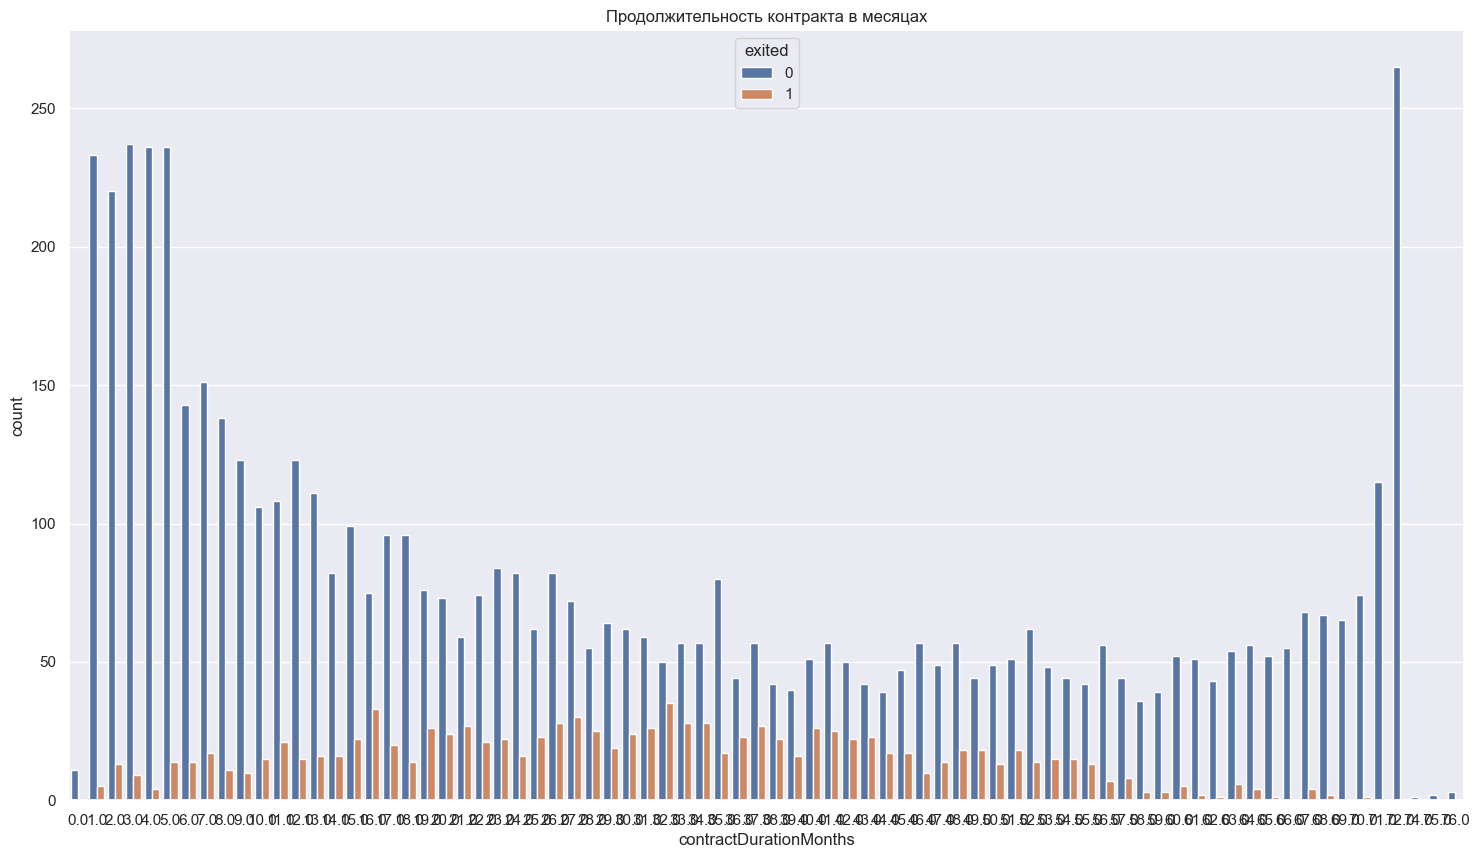

In [273]:
plt.figure(figsize=(18,10))
# sns.set()
plt.title('Продолжительность контракта в месяцах')
plt.legend(loc='upper left')
sns.countplot(
    x = round(df['contractDurationMonths']), 
    hue = df['exited']
)
plt.show()

Бизнес-метрика здесь — это убытки по двум направлениям: 1) пользователю
предложили промокоды, но он не собирался уходить (false positive), 2)
пользователю ничего не предложили и он ушёл (false negative).
AUC-ROC — метрика, которая учитывает возможность балансировать между
false posititve и false negative.
В качестве дополнительной метрики также вычислите accuracy.

Выделим из датафрейма целевой признак.

In [274]:
target = df['exited']
features = df.drop('exited', axis=1)

Определим какие признаки мы будем кодировать.

In [275]:
cats = ['type', 'paperlessBilling', 'paymentMethod', 'gender', 'seniorCitizen', 'partner', 'dependents', 'internetService', 'onlineSecurity', 'onlineBackup', 'deviceProtection', 'techSupport', 'streamingTV', 'streamingMovies', 'multipleLines']

Энкодер будем использовать внутри пайплайна вместе с кросс валидацией.

In [276]:
encoder_ohe = OneHotEncoder(
    drop='first', handle_unknown='ignore', sparse=False, dtype='int8'
)

encoder_ohe.fit(df[cats])

OneHotEncoder(drop='first', dtype='int8', handle_unknown='ignore', sparse=False)

In [277]:
# features_train2 = df.copy()
# features_train2[encoder_ohe.get_feature_names_out()]\
#       = encoder_ohe.transform(df[cats])
# features_train2 = features_train2.drop(cats, axis=1)